# Reproducibility and clustering between replicates

Here, reproducibility of gene expression profiles between replicates is evaluated. Reproducible genes are then clustered and comparisons between the two different treatments to grow gastruloids are performed. 

In [1]:
import glob
import Colors
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi

In [2]:
np.random.seed(174612)

In [3]:
g_annotate = ['TBXT','NODAL','CDX2','RSPO3','SOX1','SOX2','WNT3a','FGF8','UNCX','TCF15','ALDH1A2',
            'MESP1','MESP2','RIPPLY2','DPPA5','GATA6','MEOX1','TBX6','CYP26A1','GATA4','HAND1','TBX1','PAX6',
            'ZEB2']

# read data

In [4]:
ls ../hG0*/*_spliced.coutt.tsv

../hG01-20umAP-120h-ChiSB43/mG01_trim_star_spliced.coutt.tsv
../hG02-20umAP-120h-ChiSB43/mG02_trim_star_spliced.coutt.tsv
../hG03-20umAP-72h-Chi/mG03_trim_star_spliced.coutt.tsv
../hG04-20umAP-72h-Chi/mG04_trim_star_spliced.coutt.tsv


In [5]:
filesChi = glob.glob('../hG*Chi/*_spliced.coutt.tsv')
filesSB = glob.glob('../hG*ChiSB43/*_spliced.coutt.tsv')

In [6]:
filesChi, filesSB

(['../hG03-20umAP-72h-Chi/mG03_trim_star_spliced.coutt.tsv',
  '../hG04-20umAP-72h-Chi/mG04_trim_star_spliced.coutt.tsv'],
 ['../hG01-20umAP-120h-ChiSB43/mG01_trim_star_spliced.coutt.tsv',
  '../hG02-20umAP-120h-ChiSB43/mG02_trim_star_spliced.coutt.tsv'])

In [7]:
dfsChi = [read_csv(f, sep = '\t', index_col=0).astype(int) for f in filesChi]
dfsSB = [read_csv(f, sep = '\t', index_col=0).astype(int) for f in filesSB]

In [8]:
dfsChi[0].columns = [str(i).zfill(2) + '-hG01-chi' for i in range(len(dfsChi[0].columns))]
dfsChi[1].columns = [str(i).zfill(2) + '-hG02-chi' for i in range(len(dfsChi[1].columns))]

dfsSB[0].columns = [str(i).zfill(2) + '-hG03-sb' for i in range(len(dfsSB[0].columns))]
dfsSB[1].columns = [str(i).zfill(2) + '-hG04-sb' for i in range(len(dfsSB[1].columns))]

# normalize and prepare data, the same way as always

In [9]:
def removeGenes(df):
    genes = ['ERCC', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'RPL', 'RPS','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

def removeGmGenes(df):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    numbers = [str(i) for i in range(10)]
    gmhumangenes = []
    for idx in df.index:
        g = idx.rsplit('_')[1]
        if all([x in alphabet for x in g[:2]]) and all([x in numbers for x in g[2:-2]]) and g[-2]=='.' and g[-1] in numbers:
            gmhumangenes.append(idx)
    return df.loc[[idx for idx in df.index if idx not in gmhumangenes]]

In [10]:
def removePeakyGenes(df):
    genes = []
    for idx in df.index:
        if sum(df.loc[idx]/df.loc[idx].sum()>=0.9)>=1: # and df.loc[idx].sum()<20:
            genes.append(idx)
    return df.loc[[idx for idx in df.index if idx not in genes]] # genes

In [11]:
def filter_norm_dfs(dfs):
    fdfs = [removePeakyGenes(removeGmGenes(removeGenes(df))) for df in dfs]
    fdfs = [df.loc[df.index[df.sum(axis=1)>0]] for df in fdfs]
    nfdfs = [df.sum().mean()*df/df.sum() for df in fdfs]
    return nfdfs

nfdfsChi = filter_norm_dfs(dfsChi)
nfdfsSB = filter_norm_dfs(dfsSB)

In [12]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [13]:
znfdfsChi = [zscore(df) for df in nfdfsChi]
znfdfsSB = [zscore(df) for df in nfdfsSB]

sznfdfsChi = [scalezscore(df) for df in znfdfsChi]
sznfdfsSB = [scalezscore(df) for df in znfdfsSB]

In [14]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [15]:
mdfChi = mergeDfs(znfdfsChi)
mdfSB = mergeDfs(znfdfsSB)

In [17]:
mdfChi.to_csv('../results_postRevJan19/hGlds_Chi_zscore.tsv', sep = '\t')
mdfSB.to_csv('../results_postRevJan19/hGlds_ChiSB43_zscore.tsv', sep = '\t')

In [18]:
mdfChi = mergeDfs(nfdfsChi)
mdfSB = mergeDfs(nfdfsSB)

mdfChi.to_csv('../results_postRevJan19/hGlds_Chi_norm.tsv', sep = '\t')
mdfSB.to_csv('../results_postRevJan19/hGlds_ChiSB43_norm.tsv', sep = '\t')

# Identify reproducible genes in each timepoint

## Background model

In [14]:
def simulationCorrelations(n1, n2, N = 5000, th = 0.01):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    psdf = pd.DataFrame({'corr': sorted(ps), 'cum': np.linspace(0,1, N)})
    psdf['pval'] = 1.-psdf['cum']
    return psdf

## Correlation between genes

In [15]:
def geneCorrelation(df1, df2):
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

In [16]:
def assignPval2corr(cdf, pdf):
    cdf2 = pd.DataFrame(cdf, columns = ['corr'])
    cdf2['pv'] = 0
    for g in cdf.index:
        pv = cdf.loc[g]
        if (pdf['corr']>=pv).sum() > 0:
            p0 = pdf[pdf['corr']>=pv].iloc[0]['pval']
        else:
            p0 = 0.
        if (pdf['corr'] <pv).sum() > 0:
            p1 = pdf[pdf['corr'] <pv].iloc[-1]['pval']
        else:
            p1 = 1.
        cdf2.loc[g,'pv'] = 0.5*(p0+p1)
    cdf2['adj-pv'] = multi.fdrcorrection(cdf2['pv'],  method='indep')[1]
    return cdf2      

In [17]:
def findCorrGenes(znfdfs):
    pv_sim = {}
    corrGenes = {}
    for i1, i2 in it.combinations(range(len(znfdfs)), 2):
        pv_sim[(i1,i2)] = simulationCorrelations(n1 = len(znfdfs[i1].columns), n2 = len(znfdfs[i2].columns))
        corrGenes[(i1,i2)] = geneCorrelation(znfdfs[i1], znfdfs[i2])
        corrGenes[(i1,i2)] = assignPval2corr(corrGenes[(i1,i2)], pv_sim[(i1,i2)])
    return corrGenes

In [18]:
corrGenes_Chi = findCorrGenes(znfdfsChi)

In [19]:
corrGenes_SB = findCorrGenes(znfdfsSB)

In [20]:
pd.DataFrame(corrGenes_Chi[(0, 1)]).to_csv('../results_postRevJan19/comparison_chi_chisb43/corr_genes_chi.tsv', sep = '\t')
pd.DataFrame(corrGenes_SB[(0, 1)]).to_csv('../results_postRevJan19/comparison_chi_chisb43/corr_genes_chiSB43.tsv', sep = '\t')

In [21]:
corrGenes_Chi[(0,1)].head()

,corr,pv,adj-pv
ENSG00000000003_TSPAN6__X,0.436081,0.015903,0.119566
ENSG00000000005_TNMD__X,0.068206,0.388978,0.714873
ENSG00000000419_DPM1__20,-0.087822,0.674235,0.881720
ENSG00000000457_SCYL3__1,0.237734,0.128926,0.408589
ENSG00000000460_C1orf112__1,0.095357,0.335767,0.666476


# Gene selection for each protocol

In [22]:
pvth = 0.01
gl_chi = corrGenes_Chi[(0,1)].index[corrGenes_Chi[(0,1)]['adj-pv']<pvth]
len(gl_chi)

810

In [23]:
pvth = 0.01
gl_SB = corrGenes_SB[(0,1)].index[corrGenes_SB[(0,1)]['adj-pv']<pvth]
len(gl_SB)

1245

In [24]:
reprGenes = set(list(gl_chi)+list(gl_SB))
len(reprGenes)

1754

# check reproducibility

In [25]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [26]:
5*np.sqrt(1000)

158.11388300841895

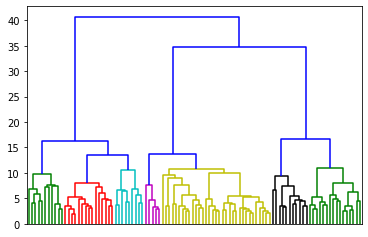

In [29]:
somhcl_Chi_df = comboCluster(mdfChi, gl_chi, cth=11)

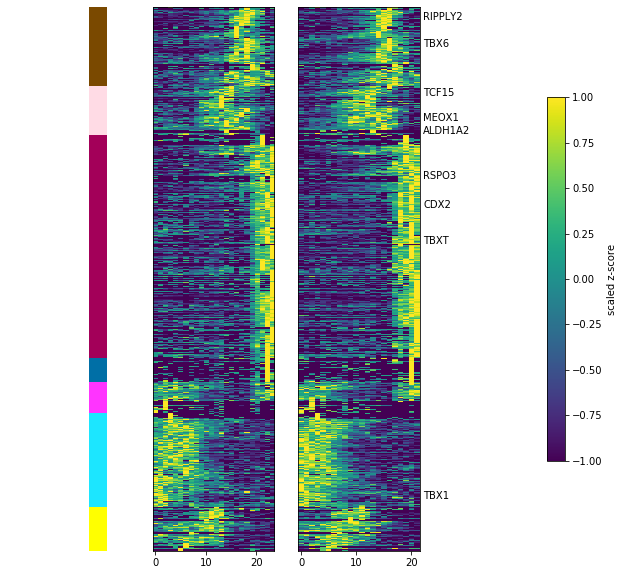

In [30]:
plt.figure(figsize=(10,10))

gene_order = somhcl_Chi_df.sort_values(by=['hcl','som']).index
Npl = len(sznfdfsChi)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_Chi_df['hcl']):
    y = 1.0*len(somhcl_Chi_df[somhcl_Chi_df['hcl'] == i])/len(somhcl_Chi_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(sznfdfsChi):
    plt.subplot(1,Npl,i+2)
    plt.imshow(df.loc[gene_order][::-1], aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft=False, labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[1] if g.rsplit('_')[1] in g_annotate else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/heatmap_Chi_reprGenes.pdf', bbox_inches = 'tight')
somhcl_Chi_df.sort_values(by=['hcl','som']).to_csv('../results_postRevJan19/comparison_chi_chisb43/clusters_Chi_reprGenes.tsv', sep = '\t')

plt.show()

In [31]:
for cl in set(somhcl_Chi_df['hcl']):
    print(cl, '&', ', '.join(sorted([g.rsplit('_')[1] for g in somhcl_Chi_df[somhcl_Chi_df['hcl']==cl].index])), '\\\\')

0 & ALCAM, B4GALNT1, BHLHE22, BOC, CD248, COLEC12, CRIP1P4, CROCCP3, DCN, DEK, DNAJC5B, EEF1A1, ERLEC1P1, FARP1, FIGNL2, FLRT2, FMOD, FOXD2, GAS1, GDF1, GREM1, HMGA2, HNRNPA1, IGFBP5, KCTD16, KDR, KIAA1109, LINC00471, LRIG3, LRRC8C-DT, LRRN3, MARCKS, MEOX2, MGAT5, MXRA8, MYLIP, MYOD1, NAP1L1, NR2F1, NR2F1-AS1, NR2F2, OSTCP2, PAX3, PCDHGA1, PDE4D, PDZRN4, PIPOX, PPM1B, PRIM1, RBBP7, RDH10, RF01684, RNU6-60P, SDK2, SEPT7P8, SIM1, SIX4, SPARC, SPSB4, STMN1, TBX18, TRIB2, UACA, VAT1L, WFIKKN1, YWHAEP5 \\
1 & ABI2, ADAM12, ADAM28, ADNP, ANKRD34B, ANO4, AP1AR, ASAP2, ATF7IP2, ATP2B1, AXL, B3GALT1, BCKDHB, BMPER, BNIP3L, BRI3, C1QTNF1, CACNA1G, CALCRL, CAP2, CDON, CELF2, CHRNA3, CIRBP, CLIP3, CLK4, CLMP, CNTFR, CNTNAP3, COL23A1, COL2A1, COL4A6, COL9A2, CPE, CPNE2, CRNDE, CXXC4, DDIT4, DLK1, DNAJC28, DNAJC6, EDNRA, EMILIN1, EPB41L3, FAM184A, FAM89A, FGF10, FOXO1, FOXP1, FXYD6, FZD4, GAS7, GPSM1, HBE1, HEPH, HMGCLL1, HS3ST3B1, HS6ST2, ID2, ID4, IFITM2, IFITM3, IRX2, IRX3, IRX5, ISL1, ITGA9, JAR

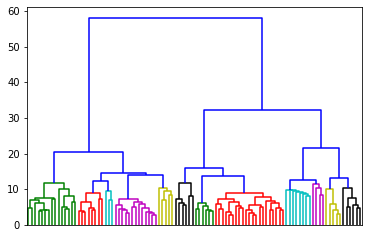

In [32]:
somhcl_SB_df = comboCluster(mdfSB, gl_SB, cth=12)

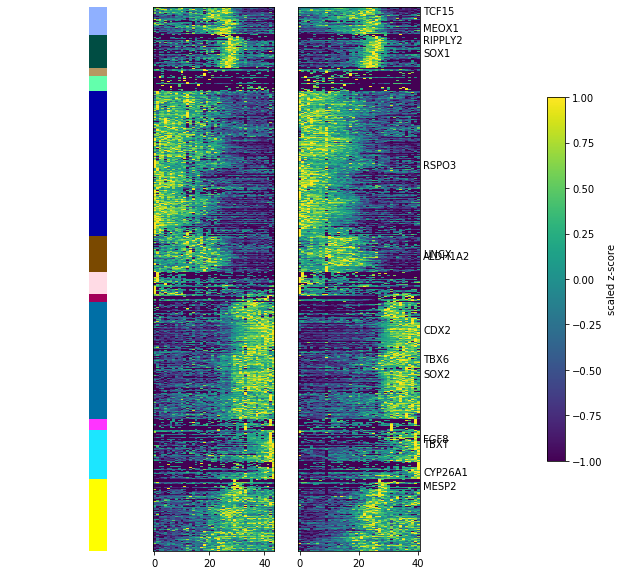

In [33]:
plt.figure(figsize=(10,10))

gene_order = somhcl_SB_df.sort_values(by=['hcl','som']).index
Npl = len(sznfdfsChi)+2
plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_SB_df['hcl']):
    y = 1.0*len(somhcl_SB_df[somhcl_SB_df['hcl'] == i])/len(somhcl_SB_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(sznfdfsSB):
    plt.subplot(1,Npl,i+2)
    plt.imshow(df.loc[gene_order][::-1], aspect = 'auto')
    plt.yticks([])
plt.tick_params(axis='y', labelleft=False, labelright='on', length = 0)
plt.yticks(range(len(gene_order)), [g.rsplit('_')[1] if g.rsplit('_')[1] in g_annotate else '' for g in gene_order[::-1]])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/heatmap_SB_reprGenes.pdf', bbox_inches = 'tight')
somhcl_SB_df.sort_values(by=['hcl','som']).to_csv('../results_postRevJan19/comparison_chi_chisb43/clusters_SB_reprGenes.tsv', sep = '\t')

plt.show()

In [34]:
for cl in set(somhcl_SB_df['hcl']):
    print(cl, '&', ', '.join(sorted([g.rsplit('_')[1] for g in somhcl_SB_df[somhcl_SB_df['hcl']==cl].index])), '\\\\')

0 & ABCG1, ACAT2, ACLY, ACSL4, ACTB, ACTR3, ADAMTS15, ADAMTS19, AKIRIN1, AMD1, ARL4C, ASRGL1, ASS1, ATP2A2, BAZ1A, CACNA1I, CCDC152, CCT6A, CD24, CDCA8, CDH2, CDK2AP1, CENPV, CFL2, CITED2, CNTN6, CR1L, CREB5, CRMP1, CTSC, CYCS, CYP51A1, DAAM1, DBI, DBN1, DDX1, DHX15, DKC1, DLL1, DLL3, DMD, DNAH11, DSP, EIF4G2, ENO1, ERG28, ETV4, FABP7, FADS1, FAM219A, FASN, FBLN1, FDFT1, FDPS, FHL2, FILIP1L, FOSL2, FOXL2, GNB1, GOLM1, GPC4, GREB1L, GREM1, GSPT1, H2AFY, HAUS6, HES6, HMGCR, HMGCS1, HNRNPA1P26, HNRNPM, HOXA1, HOXC-AS2, HOXC9, HSPE1, IARS, ID3, IDI1, INSIG1, JPT1, JUP, KIAA0408, KIF26B, LIPG, LMLN2, LMO2, LMO4, LRRC4, LRRD1, MAP1B, MARCKSL1, MESP2, MINDY2, MIR4644, MIR630, MOB3B, MSMO1, MYCN, MYH9, MYL9, MZT1, NAV1, NAV2, NELL2, NHSL1, NRP2, OIP5, ONECUT2, PAICS, PALLD, PCDH19, PCSK1, PCSK9, PDYN, PERP, PGRMC1, PHLDA2, PODXL, PRSS23, PSAT1, PSORS1C2, PTCH1, RAP1GAP2, RAP2B, RBP1, RBPMS2, RERE, RND2, RND3, RTN4, SALL4, SC5D, SCD, SELENOT, SEMA4D, SERINC5, SFPQ, SH3BP4, SH3KBP1, SINHCAF, SKA

# Cluster all together

In [35]:
mdf = mergeDfs([mdfChi, mdfSB])

In [36]:
gl_all = list(set(list(gl_chi) + list(gl_SB)))

In [37]:
import venn

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


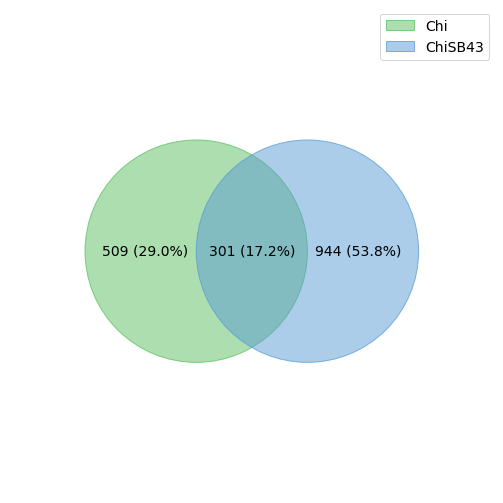

In [38]:
labels = venn.get_labels([set(gl_chi),
                          set(gl_SB)], 
                         fill=['number','percent'])

for k in labels:
    if labels[k][0:1]=='0': 
        labels[k] = ''
        
fig, ax = venn.venn2(labels, names=['Chi', 'ChiSB43'])

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/venn_genesPval01_ChiChiSB43.pdf', bbox_inches = 'tight')
plt.show()

In [39]:
len(gl_all)

1754

## Let's start with genes reproducible in both protocols

In [40]:
cnt = Counter(list(gl_chi) + list(gl_SB))
gl_both = []
for g in cnt:
    if cnt[g]==2:
        gl_both.append(g)

In [41]:
gl_both = pd.Series(gl_both)

In [42]:
len(gl_both), 5*np.sqrt(len(gl_both))

(301, 86.74675786448736)

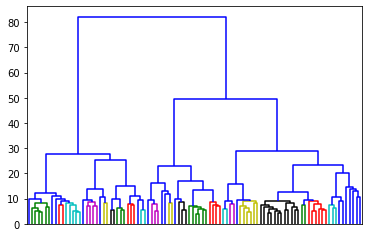

In [43]:
somhcl_all_df = comboCluster(mdf, gl_both, cth=9, gridheight=10, gridwidth=10)

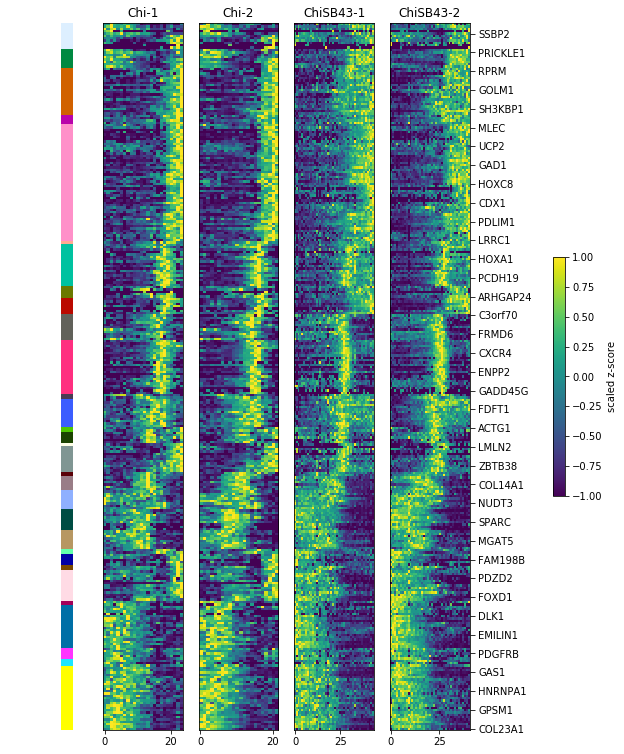

In [44]:
plt.figure(figsize=(10,13))

gene_order = somhcl_all_df.sort_values(by=['hcl','som']).index
Npl = len(sznfdfsChi)+len(sznfdfsSB)+2
titles = ['Chi-1', 'Chi-2', 'ChiSB43-1', 'ChiSB43-2']

plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_all_df['hcl']):
    y = 1.0*len(somhcl_all_df[somhcl_all_df['hcl'] == i])/len(somhcl_all_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(sznfdfsChi+sznfdfsSB):
    plt.subplot(1,Npl,i+2)
    plt.imshow(df.loc[gene_order][::-1], aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
#plt.tick_params(axis='y', labelleft=False, labelright=True, length = 4, left = False, right = True)
#plt.yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate], [g.rsplit('_')[1] for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
jidx = 4
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,8)==jidx], [g.rsplit('_')[1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,8)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/heatmap_Chi-ChiSB43_bothreprGenes.pdf', bbox_inches = 'tight')
somhcl_all_df.sort_values(by=['hcl','som']).to_csv('../results_postRevJan19/comparison_chi_chisb43/clusters_Chi-ChiSB43_bothreprGenes.tsv', sep = '\t')

plt.show()

In [45]:
for cl in set(somhcl_all_df['hcl']):
    print(cl, '&', ', '.join(sorted([g.rsplit('_')[1] for g in somhcl_all_df[somhcl_all_df['hcl']==cl].index])), '\\\\')

0 & AXL, BRI3, CDON, CIRBP, COL23A1, COL2A1, EPB41L3, FLRT2, GAS1, GPSM1, HNRNPA1, IFITM2, IFITM3, LGR4, MEIS1, MEIS2, NAP1L1, NR2F1, NR2F2, NREP, PBX1, PDGFRA, PRRX2, PRTG, RFTN2, SDK2, TPT1 \\
1 & FSTL1, HS6ST2, PDGFD \\
2 & NPHP3, PDGFRB, SERPINF1, SLC44A2, VASN \\
3 & CALCRL, CLMP, DDIT4, DLK1, EDNRA, EMILIN1, FOXP1, MARCKS, NR6A1, PCDHGA1, PCOLCE, PHLDA1, PKDCC, SHISA2, SMOC1, SOX4, TSHZ2, TWIST1 \\
4 & CD248, CXXC4 \\
5 & BGN, COL4A1, FOXD1, FOXD1-AS1, FRZB, FTL, ITM2A, ORAI3, PDZD2, RSPO3, SEMA3D, SEZ6L2, TFF3 \\
6 & ARID3B, CCND2 \\
7 & AES, FAM198B, FLRT3, ITM2C, STC1 \\
8 & CLDN11, TRIL \\
9 & BOC, FARP1, HMGA2, KDR, MGAT5, MXRA8, PAX3, RDH10 \\
10 & COL1A2, COLEC12, FMOD, FOXD2, IGFBP5, LRIG3, MEOX2, MYLIP, SPARC \\
11 & ALCAM, ALDH1A2, NUDT3, PEG10, SFRP1, SIX4, STMN1, TCF15 \\
12 & COL14A1, FBN2, FST, MXRA5, SEMA5A, ZNF704 \\
13 & CNKSR3, COL18A1 \\
14 & ASS1, BEX1, C7orf57, DSP, JUN, LFNG, LMLN2, PODXL, SERPINE2, SLIT3, ZBTB38 \\
15 & ADAMTS15 \\
16 & DKK1, NTN1, TPCN1, T

## Now only reproducible in Chi

In [46]:
gl_chiOnly = [g for g in gl_chi if g not in gl_SB]

In [47]:
gl_chiOnly = pd.Series(gl_chiOnly)

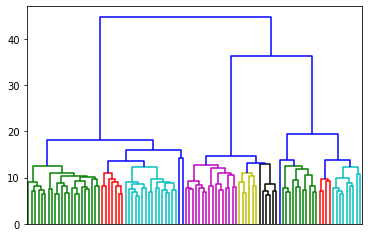

In [48]:
somhcl_chionly_df = comboCluster(mdf, gl_chiOnly, cth=13)

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


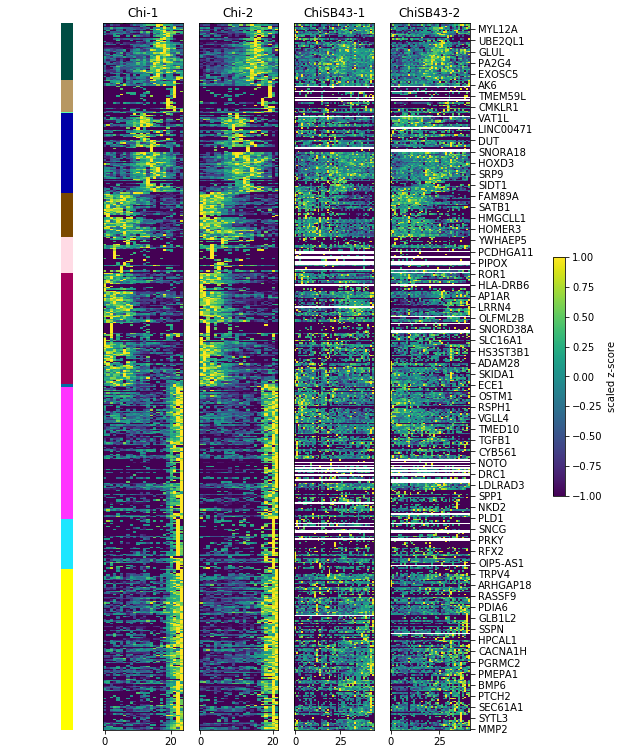

In [49]:
plt.figure(figsize=(10,13))

gene_order = somhcl_chionly_df.sort_values(by=['hcl','som']).index
Npl = len(sznfdfsChi)+len(sznfdfsSB)+2
titles = ['Chi-1', 'Chi-2', 'ChiSB43-1', 'ChiSB43-2']

plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_chionly_df['hcl']):
    y = 1.0*len(somhcl_chionly_df[somhcl_chionly_df['hcl'] == i])/len(somhcl_chionly_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(sznfdfsChi+sznfdfsSB):
    plt.subplot(1,Npl,i+2)
    plt.imshow(df.loc[gene_order][::-1], aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
#plt.tick_params(axis='y', labelleft=False, labelright=True, length = 4, left = False, right = True)
#plt.yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate], [g.rsplit('_')[1] for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
jidx = 4
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,8)==jidx], [g.rsplit('_')[1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,8)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/heatmap_Chi-ChiSB43_ChiReprGenes.pdf', bbox_inches = 'tight')
somhcl_chionly_df.sort_values(by=['hcl','som']).to_csv('../results_postRevJan19/comparison_chi_chisb43/clusters_Chi-ChiSB43_ChiReprGenes.tsv', sep = '\t')

plt.show()

## and now only reproducible in the ChiSB43

In [50]:
gl_SBOnly = [g for g in gl_SB if g not in gl_chi]

In [51]:
nfdfs = mergeDfs(nfdfsChi+nfdfsSB)
nfdfs.to_csv('../results_postRevJan19/pooledAll_chichiSB45_normfilt.tsv', sep = '\t')

In [52]:
gl_SBOnly = pd.Series(gl_SBOnly)

In [53]:
len(gl_SBOnly), 5*np.sqrt(len(gl_SBOnly))

(944, 153.62291495737216)

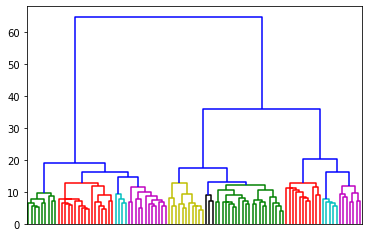

In [54]:
somhcl_SBonly_df = comboCluster(mdf, gl_SBOnly, cth=13)

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


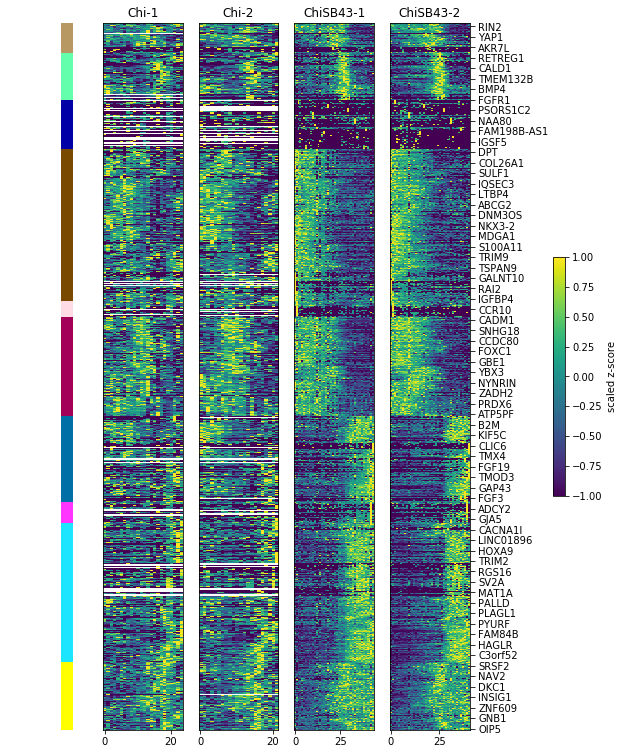

In [55]:
plt.figure(figsize=(10,13))

gene_order = somhcl_SBonly_df.sort_values(by=['hcl','som']).index
Npl = len(sznfdfsChi)+len(sznfdfsSB)+2
titles = ['Chi-1', 'Chi-2', 'ChiSB43-1', 'ChiSB43-2']

plt.subplot(1,Npl,1, frameon = False)

y0 = 0; z0 = 0; xb = 4 # 3
for i in set(somhcl_SBonly_df['hcl']):
    y = 1.0*len(somhcl_SBonly_df[somhcl_SBonly_df['hcl'] == i])/len(somhcl_SBonly_df)
    plt.bar([xb], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y       
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(2.5,4.5)

for i, df in enumerate(sznfdfsChi+sznfdfsSB):
    plt.subplot(1,Npl,i+2)
    plt.imshow(df.loc[gene_order][::-1], aspect = 'auto')
    plt.yticks([])
    plt.title(titles[i])
#plt.tick_params(axis='y', labelleft=False, labelright=True, length = 4, left = False, right = True)
#plt.yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate], [g.rsplit('_')[1] for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
jidx = 4
plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
plt.yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,14)==jidx], [g.rsplit('_')[1] for i, g in enumerate(gene_order[::-1]) if np.mod(i,14)==jidx])

plt.subplot(1,Npl, Npl, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/heatmap_Chi-ChiSB43_ChiSB43ReprGenes.pdf', bbox_inches = 'tight')
somhcl_SBonly_df.sort_values(by=['hcl','som']).to_csv('../results_postRevJan19/comparison_chi_chisb43/clusters_Chi-ChiSB43_ChiSB43ReprGenes.tsv', sep = '\t')

plt.show()

# generate a global output file

In [56]:
mdf.to_csv('../results_postRevJan19/pooledAll_chichiSB45_zscore.tsv', sep = '\t')

In [57]:
mndf = mergeDfs(nfdfsChi+nfdfsSB)

In [58]:
mndf.to_csv('../results_postRevJan19/pooledAll_chichiSB45_normfilt.tsv', sep = '\t')

In [59]:
ls ../

gene_lineages.tsv         hG02-20umAP-120h-ChiSB43/ rawdata/
gene_lineages_v2.xls      hG03-20umAP-72h-Chi/      reporters/
genes_Naomi_190619.csv    hG04-20umAP-72h-Chi/      results_postRevJan19/
hG01-20umAP-120h-ChiSB43/ notebooks/


# lineplots

In [60]:
set(somhcl_Chi_df['hcl']), set(somhcl_SB_df['hcl'])

({0, 1, 2, 3, 4, 5, 6}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11})

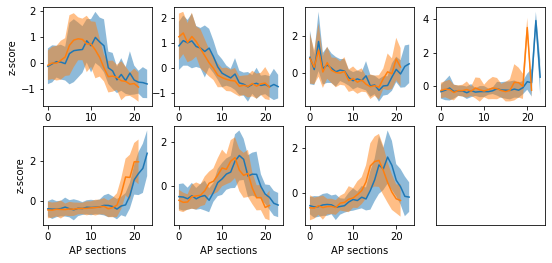

In [61]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize = (9,4))
for cl in set(somhcl_Chi_df['hcl']):
    nr = np.mod(cl,4); nc = int(cl/4)
    for df in znfdfsChi:
        x = range(len(df.columns))
        y0 = df.loc[somhcl_Chi_df[somhcl_Chi_df['hcl']==cl].index].mean()
        y1 = y0 + df.loc[somhcl_Chi_df[somhcl_Chi_df['hcl']==cl].index].std()
        y2 = y0 - df.loc[somhcl_Chi_df[somhcl_Chi_df['hcl']==cl].index].std()
        ax[nc][nr].fill_between(x, y1, y2, alpha = 0.5)
        ax[nc][nr].plot(x, y0)
    if nr == 0:
        ax[nc][nr].set_ylabel('z-score')
    if nc == 1:
        ax[nc][nr].set_xlabel('AP sections')
ax[1][3].set_xticks([]); ax[1][3].set_yticks([])
#ax[1][3].frameon(False)

plt.savefig('../results_postRevJan19/comparison_chi_chisb43/lineplots_clusters_Chi.pdf', bbox_inches = 'tight')

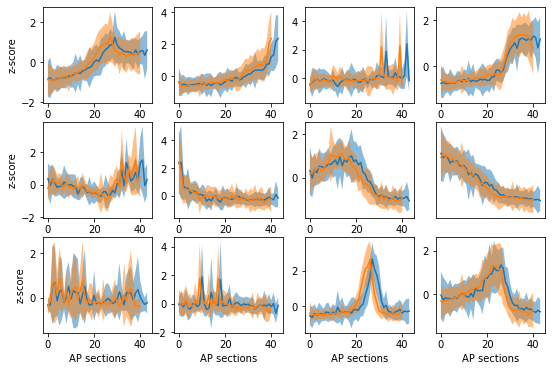

In [62]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize = (9, 6))
for cl in set(somhcl_SB_df['hcl']):
    nr = np.mod(cl,4); nc = int(cl/4)
    for df in znfdfsSB:
        x = range(len(df.columns))
        y0 = df.loc[somhcl_SB_df[somhcl_SB_df['hcl']==cl].index].mean()
        y1 = y0 + df.loc[somhcl_SB_df[somhcl_SB_df['hcl']==cl].index].std()
        y2 = y0 - df.loc[somhcl_SB_df[somhcl_SB_df['hcl']==cl].index].std()
        ax[nc][nr].fill_between(x, y1, y2, alpha = 0.5)
        ax[nc][nr].plot(x, y0)
    if nr == 0:
        ax[nc][nr].set_ylabel('z-score')
    if nc == 2:
        ax[nc][nr].set_xlabel('AP sections')
ax[1][3].set_xticks([]); ax[1][3].set_yticks([])
plt.savefig('../results_postRevJan19/comparison_chi_chisb43/lineplots_clusters_SB.pdf', bbox_inches = 'tight')